# Outline:
* [Configuration](#config)
* [Functions](#functions)
* [Loading-data](#loading-data)
* [Data-manipulation](#manipulation)
* [Representation](#representation)

# Configuration <a class='anchor' id='config'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


url_csse_covid_19_daily_reports = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                   "csse_covid_19_data/csse_covid_19_daily_reports")
url_csse_covid_19_daily_reports_us = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                      "csse_covid_19_data/csse_covid_19_daily_reports_us")

url_time_series_covid19_confirmed_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
url_time_series_covid19_deaths_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
url_time_series_covid19_recovered_global = ("https://github.com/CSSEGISandData/COVID-19/raw/master/"
 "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

url_time_series_covid19_confirmed_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
url_time_series_covid19_deaths_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
url_apple_mobility_trends = ('https://covid19-static.cdn-apple.com/covid19-mobility-data/'
                             f'2009HotfixDev19/v3/en-us/applemobilitytrends-{yesterday}.csv')
url_google_mobility_report = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# Functions <a class='anchor' id='functions'></a>

In [2]:
def load_data(url, dtype=None):    
    import os
    from six.moves import urllib
    _, filename = url.rsplit('/', 1)
    filename = str(datetime.date.today()) + '_' + filename
    filepath = 'datasets/' + filename
    if not os.path.isdir('datasets'):
        os.makedirs('datasets')
    try:
        if not os.path.exists(filepath):
            urllib.request.urlretrieve(url, filepath)
    except:
        print('Could not retrieve ' + url)
        raise
    return pd.read_csv(filepath, dtype=dtype)

def format_columns(df):
    column_mapping = {'sub_region_1': 'province_state', 'sub_region_2': 'county', 'admin2': 'county',
                 'country/region':'country_region', 'province/state': 'province_state', 'long_': 'long'}    
    dates = {}
    names = {}
    for col in df.columns:
        try:
            dates[col] = pd.to_datetime(col).date()
        except:
            names[col] = str.lower(col)
    df = df.rename(columns=names).rename(columns=dates)    
    cols_order = list(names.values()) + sorted(dates.values(), reverse=True)
    df = df[cols_order]
    df = df.rename(columns=column_mapping)
    if 'county' not in df.columns:
        df['county'] = np.nan    
    df = df.astype({'country_region': str, 'province_state': str, 'county': str})
    return df

def format_cells(df):
    df = df.copy()
    name_mapping = {'The Bahamas':'Bahamas', "Côte d'Ivoire":"Cote d'Ivoire", 'Myanmar (Burma)': 'Burma', 
                 'Korea, South': 'South Korea', 'Taiwan*':'Taiwan', 'US': 'United States'} 
    regex_mapping = {r'\s(p|P)rovince': '', r'\s(c|C)ounty': ''}
    df = df.replace(to_replace=name_mapping).replace(regex=regex_mapping)
    if 'population' in df.columns:
        df.loc[df['population'] <= 0, 'population'] = np.nan
    return df

def sparse_columns(df, sparsity_level=0.5):
    return df.columns[df.isna().sum() > df.shape[0] * sparsity_level].values


In [3]:
def get_time_series_data(url):
    df = format_cells(format_columns(load_data(url)))
    date_columns = [c for c in df.columns if isinstance(c, datetime.date)]
    # melt: Unpivots a DataFrame from wide format to long format
    df = df.melt(value_vars=date_columns,
                 id_vars=['country_region', 'province_state', 'county'], 
                 var_name='date', 
                 value_name='values')
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()

In [4]:
def get_google_mobility_data(url):
    df_mobility = load_data(url, dtype={'country_region': str, 'sub_region_1': str, 'sub_region_2': str})
    df_mobility = format_cells(format_columns(df_mobility))
    df_mobility.loc[df_mobility['country_region'] == 'Aruba', 
                    ['country_region', 'province_state']] = ('Netherlands', 'Aruba')
    df_mobility.loc[df_mobility['country_region'] == 'Réunion', 
                    ['country_region', 'province_state']] = ('France', 'Réunion')
    df_mobility.loc[df_mobility['country_region'] == 'Hong Kong'
                    , ['country_region', 'province_state']] = ('China', 'Hong Kong')
    df_mobility['mobility'] = None
    cols = df_mobility.columns[-7:-1]
    df_mobility['mobility'] = df_mobility[cols].mean(axis=1).div(100.0).round(3)
    df_mobility['date'] = pd.to_datetime(df_mobility['date'])
    df_mobility = df_mobility.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()
    return df_mobility['mobility']

In [5]:
def load_main_dataframe(date=None):
    if date is None:
        date = datetime.datetime.today().date()
    return (pd.read_csv(f'datasets/{date}_df.csv', keep_default_na=False, float_precision='round_trip',
                        index_col=['country_region', 'province_state', 'county', 'date'], 
                        dtype={'country_region':str, 'province_state':str, 'county':str},
                        parse_dates=True)
            .sort_index(level=[0,1,2,3]))

def load_yx_dataframe(date=None):
    if date is None:
        date = datetime.datetime.today().date()
    return pd.read_csv(f'datasets/{date}_df-yx.csv', float_precision='round_trip')

# Loading data <a class='anchor' id='loading-data'></a>

**Fetch time series**

In [6]:
%%time
df_global_confirmed = get_time_series_data(url_time_series_covid19_confirmed_global).rename(columns={'values':'confirmed'})
df_global_deaths = get_time_series_data(url_time_series_covid19_deaths_global).rename(columns={'values':'deaths'})
df_us_confirmed = get_time_series_data(url_time_series_covid19_confirmed_US).rename(columns={'values':'confirmed'})
df_us_deaths= get_time_series_data(url_time_series_covid19_deaths_US).rename(columns={'values':'deaths'})

df_confirmed = df_global_confirmed.append(df_us_confirmed)
df_deaths = df_global_deaths.append(df_us_deaths)
df = pd.merge(left=df_confirmed, right=df_deaths, left_index=True, right_index=True, how='inner')

Wall time: 11.4 s


In [7]:
idx = pd.IndexSlice
df.loc[idx['United States', :, :, '2020-06-03']]

confirmed  deaths
province_state county                       
nan            nan           1851520  107175
Alabama        Autauga           239       5
               Baldwin           292       9
               Barbour           177       1
               Bibb               76       1
...                              ...     ...
Wyoming        Teton             100       0
               Uinta              13       0
               Unassigned          0      16
               Washakie           37       0
               Weston              1       0

[3262 rows x 2 columns]

**Fill mobility trends in different regions of the world**

In [8]:
%%time
df_mobility = get_google_mobility_data(url_google_mobility_report)

Wall time: 19.4 s


Merge mobility with our main dataframe

In [9]:
%%time
df = pd.merge(left=df, right=df_mobility, left_index=True, right_index=True, how='inner').sort_index()

Wall time: 6.94 s


In [10]:
df.loc[idx['France', :, :, '2020-05-25': '2020-05-27']]

confirmed  deaths  mobility
country_region province_state county date                                   
France         nan            nan    2020-05-25     180166   28407    -0.163
                                     2020-05-26     179887   28480    -0.142
                                     2020-05-27     180044   28546    -0.147

# Data Manipulation <a class='anchor' id='manipulation'></a>

**Calculating *new_confirmed* and *new_deaths***

In [11]:
%%time
df[['new_confirmed', 'new_deaths']] = df[['confirmed', 'deaths']].diff()

Wall time: 35.9 ms


In [12]:
%%time
headindex, tailindex = [], []
for name, group in df.groupby(axis='index', level=[0,1,2]):    
    headindex.append(group.index.values[0])
    tailindex.append(group.index.values[-1])
headindex = pd.MultiIndex.from_tuples(headindex)
tailindex = pd.MultiIndex.from_tuples(tailindex)

Wall time: 3.54 s


In [13]:
%%time
df.loc[headindex, 'new_confirmed'] = df.loc[headindex, 'confirmed']
df.loc[headindex, 'new_deaths'] = df.loc[headindex, 'deaths']

Wall time: 491 ms


In [14]:
df['new_deaths'] = df['new_deaths'].astype('int64')
df['new_confirmed'] = df['new_confirmed'].astype('int64')
df = df[['mobility', 'confirmed', 'new_confirmed', 'deaths', 'new_deaths']]

**Calculating a *baseline*, and change rates of deaths/confirmed based on this baseline**

In [15]:
baseline_start_date = pd.to_datetime('2020-04-01')
baseline_end_date = pd.to_datetime('2020-04-30')
print(f'baseline period: {baseline_start_date} to {baseline_end_date}')
df['baseline_period_'] = f'{baseline_start_date.date()}_{baseline_end_date.date()}'

baseline period: 2020-04-01 00:00:00 to 2020-04-30 00:00:00


In [16]:
%%time
# only consider the view of the dataframe during baseline_start/end_time, then find median along first three index
idx_bp = idx[:, :, :, baseline_start_date: baseline_end_date]
df['n_c_baseline_'] = df.loc[idx_bp, 'new_confirmed'].median(axis=0, level=[0,1,2])
df['n_d_baseline_'] = df.loc[idx_bp, 'new_deaths'].median(axis=0, level=[0,1,2])
# set baseline to 1 for those countries that baseline is 0
df['1'] = 1
df['n_c_baseline_'] = df[['n_c_baseline_', '1']].max(axis=1)
df['n_d_baseline_'] = df[['n_d_baseline_', '1']].max(axis=1)

# slower version:
# for name, group in df.groupby(axis='index', level=[0,1,2]):
#     start_index = (*name, baseline_start_date)
#     end_index = (*name, baseline_end_date)
#     n_c_baseline = max(1, df.loc[idx[start_index: end_index], 'new_confirmed'].median())
#     n_d_baseline = max(1, df.loc[idx[start_index: end_index], 'new_deaths'].median())
#     df.loc[name, 'n_c_baseline_'] = n_c_baseline
#     df.loc[name, 'n_d_baseline_'] = n_d_baseline

Wall time: 2.14 s


In [17]:
df['n_c_change'] = (((df['new_confirmed'] - df['n_c_baseline_']) / df['n_c_baseline_'])
                                    .round(3))
df['n_d_change'] = (((df['new_deaths'] - df['n_d_baseline_']) / df['n_d_baseline_'])
                                .round(3))

Clean up dataframe

In [18]:
# drop column '1' and rearrange them
# df.drop(axis=1, labels='1', inplace=True)
df = df[['mobility', 
         'confirmed', 'new_confirmed', 'n_c_change', 
         'deaths', 'new_deaths', 'n_d_change', 
         'n_c_baseline_', 'n_d_baseline_', 'baseline_period_']]
df.loc[idx['Afghanistan': 'Angola'],]

mobility  confirmed  \
country_region province_state county date                              
Afghanistan    nan            nan    2020-02-15    -0.073          0   
                                     2020-02-16     0.048          0   
                                     2020-02-17     0.053          0   
                                     2020-02-18     0.042          0   
                                     2020-02-19     0.015          0   
...                                                   ...        ...   
Angola         nan            nan    2020-05-25    -0.200         70   
                                     2020-05-26    -0.163         70   
                                     2020-05-27    -0.142         71   
                                     2020-05-28    -0.112         74   
                                     2020-05-29    -0.103         81   

                                                 new_confirmed  n_c_change  \
country_region province_state county date                                    
Afghanistan    nan            nan    2020-02-15              0        -1.0   
                                     2020-02-16              0        -1.0   
                                     2020-02-17              0        -1.0   
                                     2020-02-18              0        -1.0   
                                     2020-02-19              0        -1.0   
...                                                        ...         ...   
Angola         nan            nan    2020-05-25              1         0.0   
                                     2020-05-26              0        -1.0   
                                     2020-05-27              1         0.0   
                                     2020-05-28              3         2.0   
                                     2020-05-29              7         6.0   

                                                 deaths  new_deaths  \
country_region province_state county date                             
Afghanistan    nan            nan    2020-02-15       0           0   
                                     2020-02-16       0           0   
                                     2020-02-17       0           0   
                                     2020-02-18       0           0   
                                     2020-02-19       0           0   
...                                                 ...         ...   
Angola         nan            nan    2020-05-25       4           0   
                                     2020-05-26       4           0   
                                     2020-05-27       4           0   
                                     2020-05-28       4           0   
                                     2020-05-29       4           0   

                                                 n_d_change  n_c_baseline_  \
country_region province_state county date                                    
Afghanistan    nan            nan    2020-02-15        -1.0           57.0   
                                     2020-02-16        -1.0           57.0   
                                     2020-02-17        -1.0           57.0   
                                     2020-02-18        -1.0           57.0   
                                     2020-02-19        -1.0           57.0   
...                                                     ...            ...   
Angola         nan            nan    2020-05-25        -1.0            1.0   
                                     2020-05-26        -1.0            1.0   
                                     2020-05-27        -1.0            1.0   
                                     2020-05-28        -1.0            1.0   
                                     2020-05-29        -1.0            1.0   

                                                 n_d_baseline_  \
country_region province_state county date                        
Afghanistan    nan        

**Saving DF dataset:**

In [19]:
%%time
print('Dataset shape:', df.shape)
print('Dataset columns: ', df.columns.ravel())
today = datetime.datetime.today().date()
df.to_csv(f'datasets/{today}_df.csv', index=True)
pd.testing.assert_frame_equal(df, load_main_dataframe(today))

Dataset shape: (285580, 10)
Dataset columns:  ['mobility' 'confirmed' 'new_confirmed' 'n_c_change' 'deaths' 'new_deaths'
 'n_d_change' 'n_c_baseline_' 'n_d_baseline_' 'baseline_period_']
Wall time: 11.7 s


**Building DF_YX:**

In [20]:
week = pd.Timedelta('7 days')
day = pd.Timedelta('1 day')
closing_date = df.index.levels[3].max()
x_period = (closing_date - 5 * week - day, closing_date - week - day)
y_period = (closing_date - week, closing_date)
print('X period:', x_period)
print('Y period:', y_period)
df_x = df.loc[idx[:,:,:, x_period[0]: x_period[1]], ['mobility', 'n_c_change', 'n_d_change']].copy()
df_y = df.loc[idx[:,:,:, y_period[0]: y_period[1]], ['n_c_baseline_', 'n_d_baseline_','mobility', 'n_c_change', 'n_d_change']].copy()

X period: (Timestamp('2020-04-23 00:00:00'), Timestamp('2020-05-21 00:00:00'))
Y period: (Timestamp('2020-05-22 00:00:00'), Timestamp('2020-05-29 00:00:00'))


*df_y*

In [21]:
df_y = df_y.mean(axis=0, level=[0,1,2])
df_y.columns = df_y.columns[:2].tolist() + [f'avg({c})' for c in df_y.columns[2:]]
df_y['Y_period'] = f'{y_period[0].date()}_{y_period[1].date()}'
df_y['X_period'] = f'{x_period[0].date()}_{x_period[1].date()}'
df_y.head(3)

,,,n_c_baseline_,n_d_baseline_,avg(mobility),avg(n_c_change),avg(n_d_change),Y_period,X_period
country_region,province_state,county,,,,,,,
Afghanistan,nan,nan,57.0,2.0,-0.254375,9.927625,2.3125,2020-05-22_2020-05-29,2020-04-23_2020-05-21
Angola,nan,nan,1.0,1.0,-0.165875,1.875000,-0.8750,2020-05-22_2020-05-29,2020-04-23_2020-05-21
Antigua and Barbuda,nan,nan,1.0,1.0,-0.255125,-1.000000,-1.0000,2020-05-22_2020-05-29,2020-04-23_2020-05-21


*df_x*

In [22]:
df_x = (df_x
        .reset_index()
        .pivot_table(values=['mobility', 'n_c_change', 'n_d_change'], 
                     index=['country_region', 'province_state', 'county'], 
                     columns=['date']))
df_x.columns = [f'X_{x[0]}_{x[1].date()}' for x in df_x.columns]

In [23]:
df_x.head(3)

,,,X_mobility_2020-04-23,X_mobility_2020-04-24,X_mobility_2020-04-25,X_mobility_2020-04-26,X_mobility_2020-04-27,X_mobility_2020-04-28,X_mobility_2020-04-29,X_mobility_2020-04-30,X_mobility_2020-05-01,X_mobility_2020-05-02,...,X_n_d_change_2020-05-12,X_n_d_change_2020-05-13,X_n_d_change_2020-05-14,X_n_d_change_2020-05-15,X_n_d_change_2020-05-16,X_n_d_change_2020-05-17,X_n_d_change_2020-05-18,X_n_d_change_2020-05-19,X_n_d_change_2020-05-20,X_n_d_change_2020-05-21
country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
Afghanistan,nan,nan,-0.252,-0.223,-0.270,-0.275,-0.305,-0.267,-0.240,-0.267,-0.223,-0.270,...,1.5,1.5,1.0,7.5,6.5,-0.5,1.0,1.5,3.5,2.0
Angola,nan,nan,-0.340,-0.352,-0.262,-0.280,-0.252,-0.205,-0.210,-0.165,-0.358,-0.177,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
Antigua and Barbuda,nan,nan,-0.524,-0.508,-0.504,-0.554,-0.367,-0.375,-0.353,-0.342,-0.323,-0.446,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


*df_yx*

In [24]:
df_yx = (pd.merge(left=df_y, right=df_x, left_index=True, right_index=True, how='inner')
         .reset_index())
df_yx[['country_region', 'province_state', 'county']] = \
                df_yx[['country_region', 'province_state', 'county']].replace('nan', '')
df_yx['country_region'] = df_yx['country_region'] + df_yx['province_state'] + df_yx['county']
df_yx = df_yx.drop(axis=1, labels=['province_state', 'county']).rename(columns={'country_region':'location'})
df_yx.head(3)

,location,n_c_baseline_,n_d_baseline_,avg(mobility),avg(n_c_change),avg(n_d_change),Y_period,X_period,X_mobility_2020-04-23,X_mobility_2020-04-24,...,X_n_d_change_2020-05-12,X_n_d_change_2020-05-13,X_n_d_change_2020-05-14,X_n_d_change_2020-05-15,X_n_d_change_2020-05-16,X_n_d_change_2020-05-17,X_n_d_change_2020-05-18,X_n_d_change_2020-05-19,X_n_d_change_2020-05-20,X_n_d_change_2020-05-21
0,Afghanistan,57.0,2.0,-0.254375,9.927625,2.3125,2020-05-22_2020-05-29,2020-04-23_2020-05-21,-0.252,-0.223,...,1.5,1.5,1.0,7.5,6.5,-0.5,1.0,1.5,3.5,2.0
1,Angola,1.0,1.0,-0.165875,1.875000,-0.8750,2020-05-22_2020-05-29,2020-04-23_2020-05-21,-0.340,-0.352,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2,Antigua and Barbuda,1.0,1.0,-0.255125,-1.000000,-1.0000,2020-05-22_2020-05-29,2020-04-23_2020-05-21,-0.524,-0.508,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


**Saving DF_YX dataset:**

In [25]:
print('Dataset shape:', df_yx.shape)
print('Dataset columns: ', df_yx.columns)
today = datetime.datetime.today().date()
df_yx.to_csv(f'datasets/{today}_df-yx.csv', index=False)
assert(df_yx.equals(load_yx_dataframe(today))), 'Saved dataset does not match newly loaded one'

Dataset shape: (2863, 95)
Dataset columns:  Index(['location', 'n_c_baseline_', 'n_d_baseline_', 'avg(mobility)',
       'avg(n_c_change)', 'avg(n_d_change)', 'Y_period', 'X_period',
       'X_mobility_2020-04-23', 'X_mobility_2020-04-24',
       'X_mobility_2020-04-25', 'X_mobility_2020-04-26',
       'X_mobility_2020-04-27', 'X_mobility_2020-04-28',
       'X_mobility_2020-04-29', 'X_mobility_2020-04-30',
       'X_mobility_2020-05-01', 'X_mobility_2020-05-02',
       'X_mobility_2020-05-03', 'X_mobility_2020-05-04',
       'X_mobility_2020-05-05', 'X_mobility_2020-05-06',
       'X_mobility_2020-05-07', 'X_mobility_2020-05-08',
       'X_mobility_2020-05-09', 'X_mobility_2020-05-10',
       'X_mobility_2020-05-11', 'X_mobility_2020-05-12',
       'X_mobility_2020-05-13', 'X_mobility_2020-05-14',
       'X_mobility_2020-05-15', 'X_mobility_2020-05-16',
       'X_mobility_2020-05-17', 'X_mobility_2020-05-18',
       'X_mobility_2020-05-19', 'X_mobility_2020-05-20',
       'X_mobility_

# Representation <a class='anchor' id='representation'></a>

In [26]:
%matplotlib inline

In [27]:
df = load_main_dataframe()

In [28]:
df.columns

Index(['mobility', 'confirmed', 'new_confirmed', 'n_c_change', 'deaths',
       'new_deaths', 'n_d_change', 'n_c_baseline_', 'n_d_baseline_',
       'baseline_period_'],
      dtype='object')

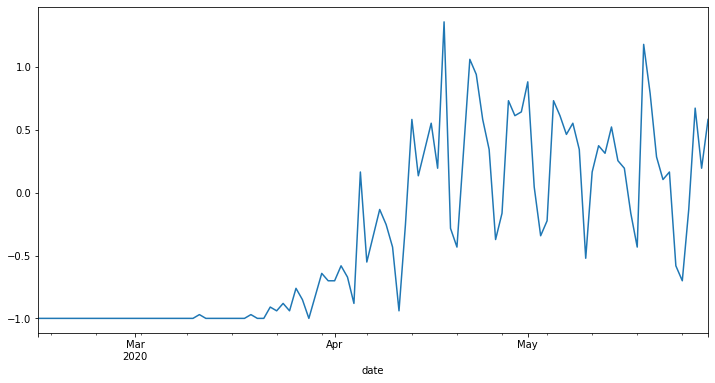

In [29]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'n_d_change'].plot(figsize=(12, 6))

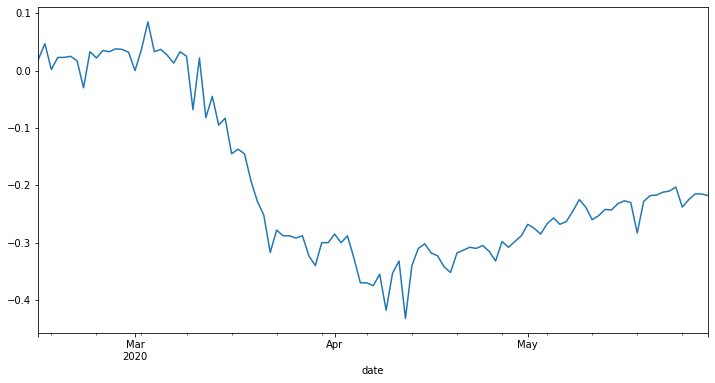

In [30]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'mobility'].plot(figsize=(12, 6))